In [1]:
!pwd

/home/programmer/Desktop/general/End-To-End-MLOps-Project/notebooks


In [2]:
import os 

os.chdir("../")
!pwd

/home/programmer/Desktop/general/End-To-End-MLOps-Project


In [3]:
from src.utils.common import read_yaml
from src.constants import PARAMS_FILE_PATH

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score,
                            f1_score, 
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            auc,
                            roc_curve,
                            RocCurveDisplay)

import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [11]:
params_path = read_yaml(PARAMS_FILE_PATH)

train_path = params_path.split_data.train_path
test_path = params_path.split_data.test_path

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head()

[2023-07-08 18:10:20,428: INFO: common: yaml file: params.yaml loaded successfully]


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,27.0,0,0,0,2,0,80.22,22.5,2,0
1,0,34.0,0,0,1,2,1,76.42,27.6,3,0
2,1,59.0,0,0,1,2,1,175.00,35.8,1,1
3,0,30.0,0,0,1,2,1,80.19,22.5,2,0
4,0,79.0,1,0,0,0,1,98.02,22.5,1,1


In [5]:
X_train = df_train.drop(['stroke'], axis=1)
y_train = df_train['stroke']
X_test = df_test.drop(['stroke'], axis=1)
y_test = df_test['stroke']

In [6]:
X_train[:5]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,27.0,0,0,0,2,0,80.22,22.5,2
1,0,34.0,0,0,1,2,1,76.42,27.6,3
2,1,59.0,0,0,1,2,1,175.00,35.8,1
3,0,30.0,0,0,1,2,1,80.19,22.5,2
4,0,79.0,1,0,0,0,1,98.02,22.5,1


In [7]:
def model_with_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    
    '''

    # Random seed for reproducible results
    np.random.seed(42)

    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [8]:
models = {"RandomForest": RandomForestClassifier(),
          "KNN": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(),
          "DecisionTree": DecisionTreeClassifier(),
          "GradientBoostingClassifier": GradientBoostingClassifier(),
          "XGboost": XGBClassifier()}

model_scores = model_with_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'RandomForest': 0.9902263374485597,
 'KNN': 0.926440329218107,
 'SVC': 0.7587448559670782,
 'LogisticRegression': 0.7731481481481481,
 'DecisionTree': 0.9711934156378601,
 'GradientBoostingClassifier': 0.8621399176954733,
 'XGboost': 0.9783950617283951}

In [12]:
import mlflow

remote_server_uri = params_path.mlflow_config.remote_server_uri
experiment_name = params_path.mlflow_config.experiment_name

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)

2023/07/08 18:10:24 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/programmer/Desktop/general/End-To-End-MLOps-Project/artifacts/2', creation_time=1688820024110, experiment_id='2', last_update_time=1688820024110, lifecycle_stage='active', name='Random_Forest', tags={}>

In [13]:
# fun to create confusion matrix
def create_confusion_matrix_plot(clf,y_test, predictions):
    
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=clf.classes_) 
    disp.plot()
    plt.savefig('confusion_matrix.png')


# fun to create roc_curve
def create_roc_auc_plot(y_test, predictions):

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                     estimator_name='example estimator')
    disp.plot()
    plt.savefig('roc_auc_curve.png')

In [14]:
def Mlflow_Model_Hyperparametrs():
    with mlflow.start_run(run_name=params_path.mlflow_config.run_name) as mlops_run:
        # Define a grid of hyperparameters
        grid = {"n_estimators": [10, 100, 200, 500],
                'criterion': ['gini', 'entropy', 'log_loss'],
                "max_depth": [None, 5, 10, 20, 30],
                "min_samples_split": [2, 4, 6],
                "min_samples_leaf": [1, 2, 4]
               }
        # run a randomized search cv
        rs_RFC = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                    param_distributions=grid,
                                    n_iter=5,
                                    verbose=True)

        rs_RFC.fit(X_train, y_train)
        
        #mlflow.sklearn.autolog()

        # loging the best params
        run_params = rs_RFC.best_params_
        for param in run_params:
            mlflow.log_param(param, run_params[param])


        # train RandomForest with best params
        model = RandomForestClassifier(**run_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acu = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred)

        # loging accuracy and f1_score        
        mlflow.log_metric("acu", acu)
        mlflow.log_metric("f1_score", f1score)
        print(acu)

        # confusion matrix
        create_confusion_matrix_plot(model, y_test, y_pred)
        mlflow.log_artifact('confusion_matrix.png', 'confusion_materix')

        # roc curve plot
        create_roc_auc_plot(y_test, y_pred)
        mlflow.log_artifact('roc_auc_curve.png', "roc_auc_plot")

        # Save the model using mlflow.<framework>.log_model()
        mlflow.sklearn.log_model(model, 'models_mlflow') 



Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9794238683127572


2023/07/08 18:12:04 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


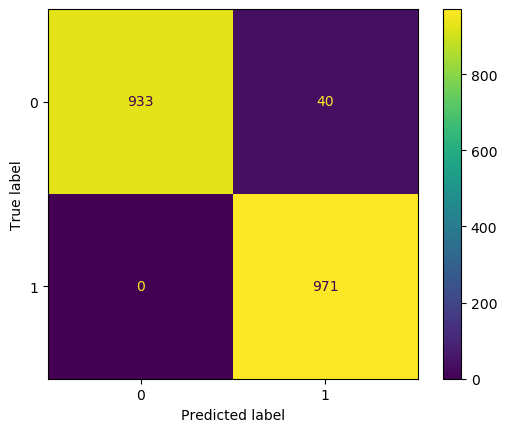

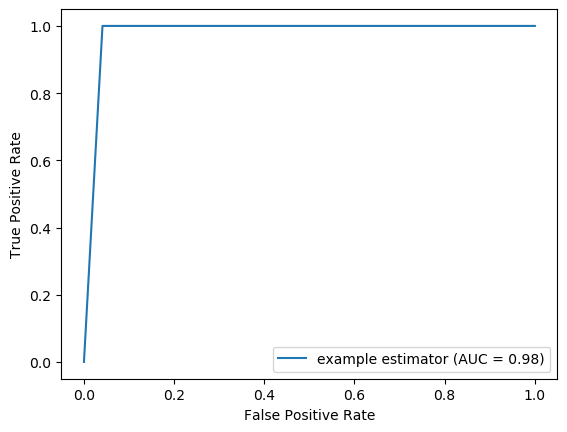

In [15]:
Mlflow_Model_Hyperparametrs()